Uses Matplotlib, pandas, and openpxyl
Serves to learn more about our first Data

**0. Installing Dependencies**

In [3]:
#Dependencies
%pip install openpyxl matplotlib pandas seaborn -q

Note: you may need to restart the kernel to use updated packages.


**1. Retrieving Data**

In [4]:
import pandas as pd
file_path = '../../Data/EnergieUebersichtCH-2024.xlsx' 
xls = pd.ExcelFile(file_path)
#Data in this case in the 3rd sheet Zeitreihen0h15
df = pd.read_excel(xls, sheet_name='Zeitreihen0h15', header=1, nrows=300)
print(df.columns)


Index(['Zeitstempel', 'kWh', 'kWh.1', 'kWh.2', 'kWh.3', 'kWh.4', 'kWh.5',
       'kWh.6', 'kWh.7', 'kWh.8', 'kWh.9', 'kWh.10', 'kWh.11', 'kWh.12',
       'kWh.13', 'kWh.14', 'kWh.15', 'kWh.16', 'kWh.17', 'kWh.18', 'kWh.19',
       'Euro/MWh', 'Euro/MWh.1', 'Euro/MWh.2', 'Euro/MWh.3', 'kWh.20',
       'kWh.21', 'kWh.22', 'kWh.23', 'kWh.24', 'kWh.25', 'kWh.26', 'kWh.27',
       'kWh.28', 'kWh.29', 'kWh.30', 'kWh.31', 'kWh.32', 'kWh.33', 'kWh.34',
       'kWh.35', 'kWh.36', 'kWh.37', 'kWh.38', 'kWh.39', 'kWh.40', 'kWh.41',
       'kWh.42', 'kWh.43', 'kWh.44', 'kWh.45', 'kWh.46', 'kWh.47', 'kWh.48',
       'kWh.49', 'kWh.50', 'kWh.51', 'kWh.52', 'kWh.53', 'kWh.54', 'kWh.55',
       'kWh.56', 'kWh.57', 'kWh.58', 'kWh.59'],
      dtype='object')


**2. Data variables / potential parameters** 

**Pre-processing step** Renaming column names to be clear

In [5]:
column_mapping = {
    'kWh': 'Total Energy Consumed by End Users (kWh)',
    'kWh.1': 'Total Energy Production (kWh)',
    'kWh.2': 'Total Energy Consumption (kWh)',
    'kWh.3': 'Net Outflow (kWh)',
    'kWh.4': 'Grid Feed-In (kWh)',
    'kWh.5': 'Positive Secondary Control Energy (kWh)',
    'kWh.6': 'Negative Secondary Control Energy (kWh)',
    'kWh.7': 'Positive Tertiary Control Energy (kWh)',
    'kWh.8': 'Negative Tertiary Control Energy (kWh)'
}

df.rename(columns=column_mapping, inplace=True)


**3. Data variables Explanation**

**A. Total Energy Consumed by End Users in the Swiss Control Block** The total of the end-user energy consumption in the Swiss control area.

**B. Total Energy Production in the Swiss Control Block**
The total amount of energy generated within the Swiss control area, including power from hydroelectric, nuclear, solar, and other sources.

**C. Total Energy Consumption in the Swiss Control Block**
The total energy used within the Swiss control area, including end-user consumption and grid losses.

**D. Net Outflow of the Swiss Transmission Grid**
The balance of electricity flowing out of the Swiss transmission grid, calculated as exports minus imports.

**E. Grid Feed-In Swiss Transmission Grid**
The total amount of energy fed into the Swiss transmission grid from various power generation sources.

**F. Positive Secondary Control Energy**
The amount of additional energy supplied to stabilize the grid when demand exceeds supply, helping to maintain frequency stability.

**G. Negative Secondary Control Energy**
The amount of energy reduced or removed from the grid when supply exceeds demand, balancing the system.



**H. Positive Tertiary Control Energy**
Additional energy reserves activated to stabilize the grid in case secondary control is insufficient, typically used for longer durations.


**I. Negative Tertiary Control Energy**
The reduction of energy fed into the grid to restore balance when supply exceeds demand over a longer period.

Mathematical relationships:

C=A+Grid Losses

Total Energy Consumption in the Swiss Control Block = Total Energy Consumption by end-users + Grid Losses

Grid Losses could be a useful variable!

Net outflow = Exports − Imports

Correlation Matrix for the first 4 Energy Variables:

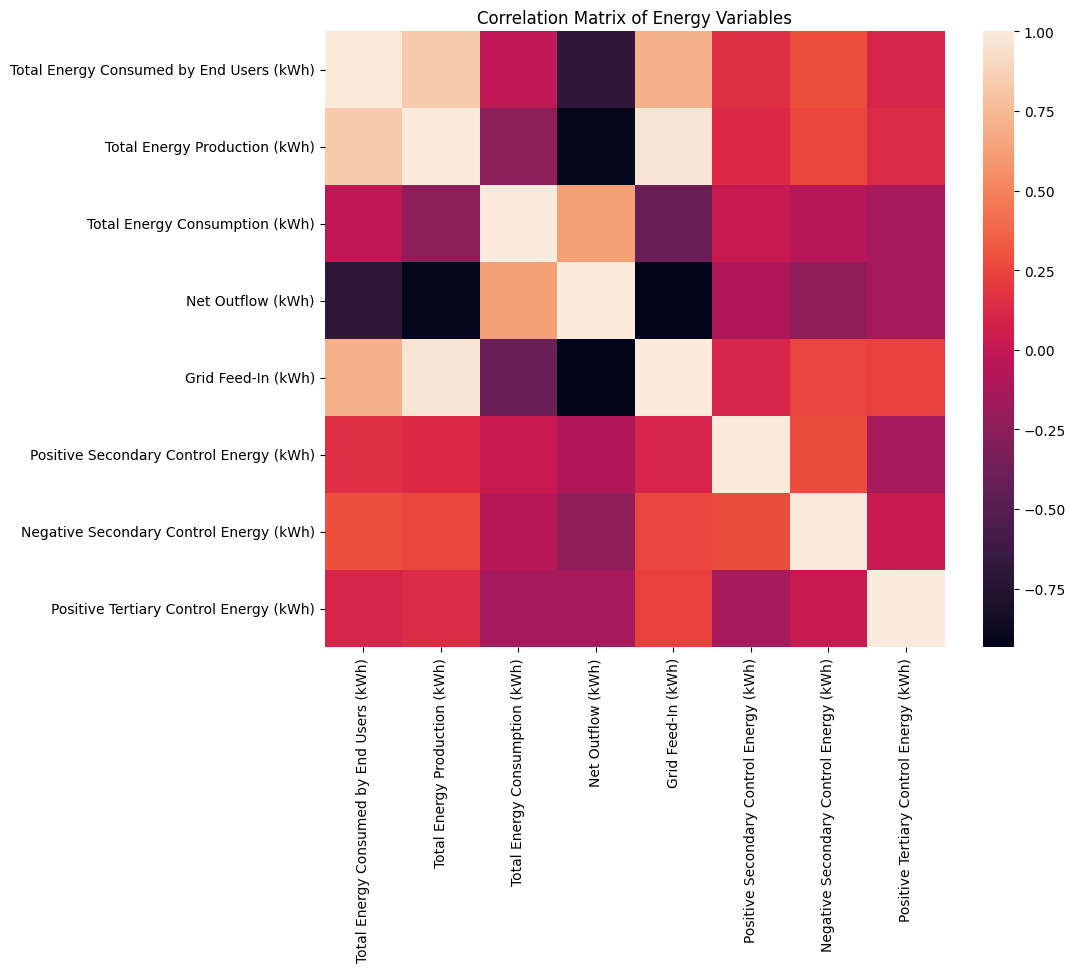

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

#subsetting without time columbn
df_subset = df.iloc[:, 1:9]
correlation_matrix = df_subset.corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix)
plt.title("Correlation Matrix of Energy Variables")
plt.show()


Autocorellation, Cross-correllation, definir les y à prédire, definir l'horizon, definir les x, 

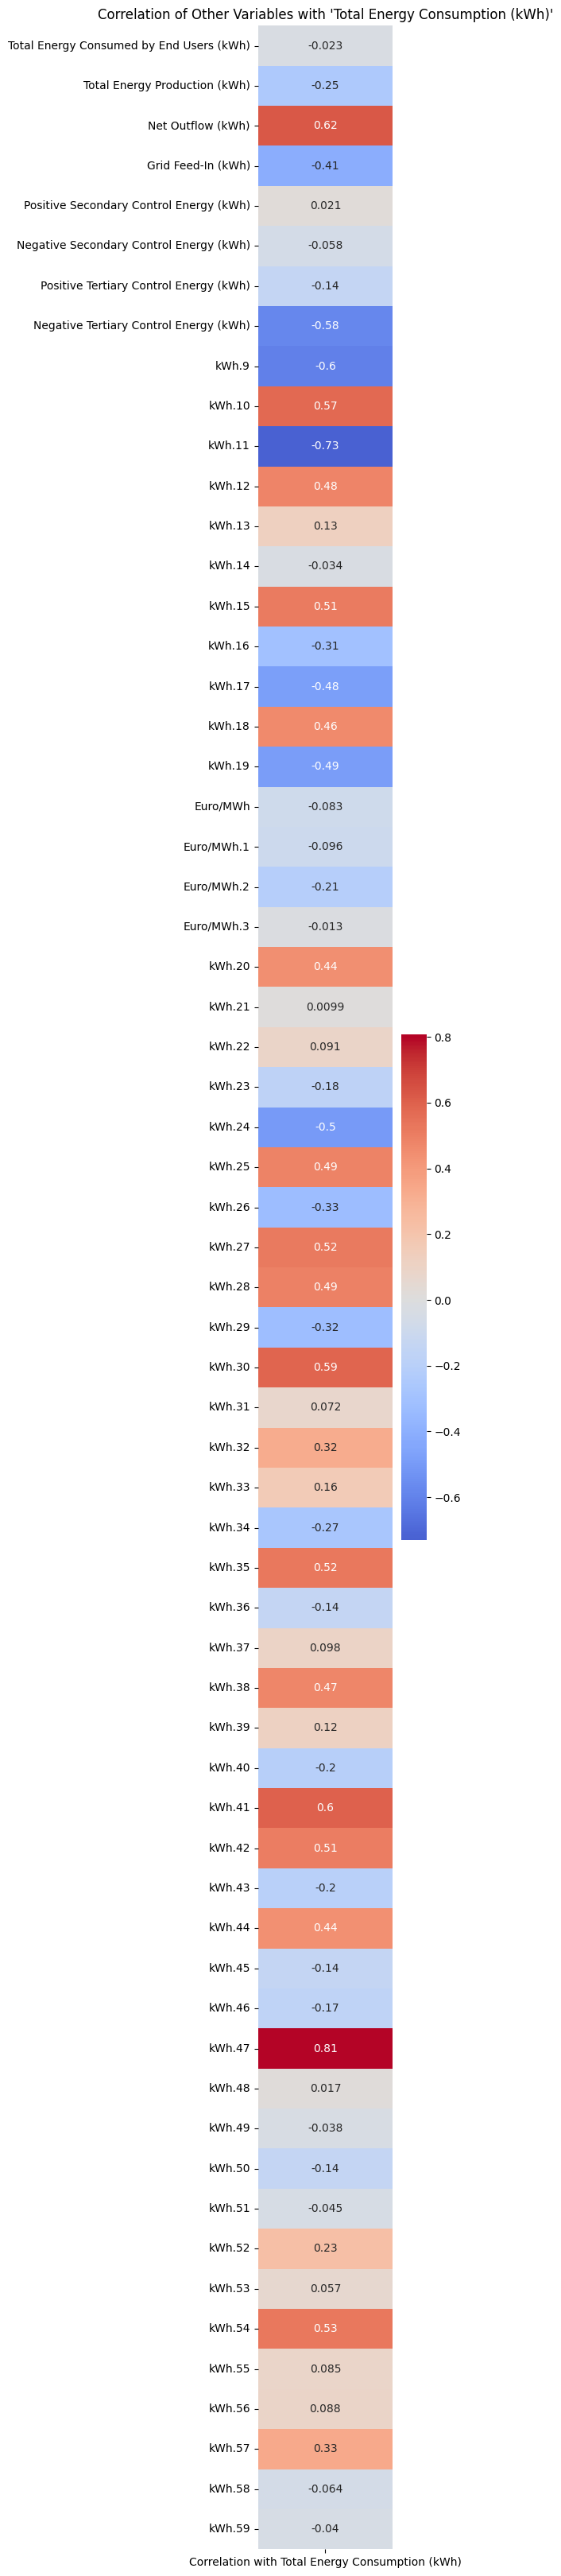

In [7]:
reference_col = df.columns[3]

df_subset = df.iloc[:, 1:]

# 3. Compute correlation with reference column
correlation_vector = df_subset.corr()[reference_col].drop(reference_col)

correlation_df = correlation_vector.to_frame(name=f"Correlation with {reference_col}")

# 5. Plot heatmap
plt.figure(figsize=(6, len(correlation_df) * 0.5 + 1))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", center=0, cbar=True)
plt.title(f"Correlation of Other Variables with '{reference_col}'")
plt.tight_layout()
plt.show()



In [16]:
%pip install xarray cfgrib eccodes -q
import cdsapi
c = cdsapi.Client()
lat_min = 45.8
lat_max = 48.5
lon_min = 5.9
lon_max = 10.5
import xarray as xr

# Open GRIB file using cfgrib engine
import xarray as xr
import pandas as pd

# Load and subset Switzerland region
ds = xr.open_dataset("../../Data/Weather/Seasonal forecast anomalies on single levels.grib", engine="cfgrib")
swiss = ds['t2a'].sel(
    latitude=slice(48.5, 45.8),
    longitude=slice(5.9, 10.5)
)

# Average over lat/lon and ensemble members → monthly anomalies
monthly_avg = swiss.mean(dim=['latitude', 'longitude', 'number'])

# Further average over lead time steps (optional: or pick just step=0)
monthly_mean = monthly_avg.mean(dim='step')

# Create weekly date range covering the same period
start_date = pd.to_datetime(monthly_mean.time.values[0])
end_date = pd.to_datetime(monthly_mean.time.values[-1]) + pd.DateOffset(months=1)  # buffer

# Generate weekly dates (every Monday)
weekly_dates = pd.date_range(start=start_date, end=end_date, freq='W-MON')

# Interpolate from monthly to weekly using xarray
weekly_interp = monthly_mean.interp(time=weekly_dates)

# Optional: convert to pandas
weekly_temp_anomaly = weekly_interp.to_series()

# Preview
print(weekly_temp_anomaly.head(10))


Note: you may need to restart the kernel to use updated packages.


/opt/homebrew/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


time
2021-01-04    0.264809
2021-01-11    0.342694
2021-01-18    0.420579
2021-01-25    0.498464
2021-02-01    0.576348
2021-02-08    0.570841
2021-02-15    0.565334
2021-02-22    0.559826
2021-03-01    0.554319
2021-03-08    0.560511
Name: t2a, dtype: float64


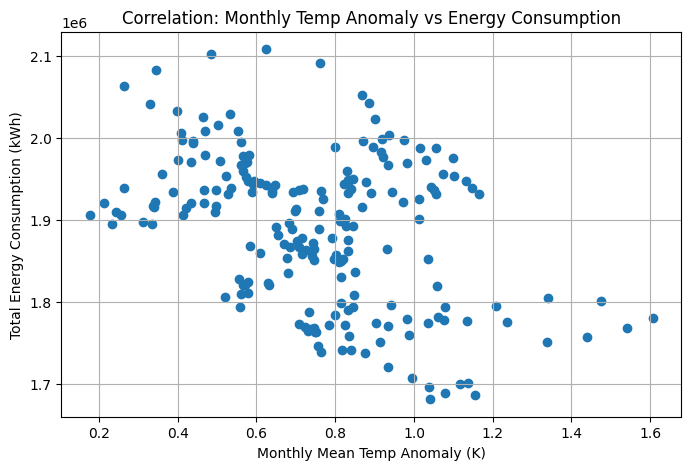

Correlation coefficient: -0.415


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime alignment
weekly_interp_dates = pd.to_datetime(weekly_interp.time.values)  # weekly_interp is an xarray DataArray
energy_time = pd.to_datetime(df.iloc[:, 0])  # if first column is date
energy_col = 'Total Energy Consumption (kWh)'

# Create pandas Series for both
weekly_temp_series = pd.Series(weekly_interp.values, index=weekly_interp_dates)
energy_series = pd.Series(df[energy_col].values, index=energy_time)

# Align to common date range
common_start = max(weekly_temp_series.index.min(), energy_series.index.min())
common_end = min(weekly_temp_series.index.max(), energy_series.index.max())

weekly_temp_series = weekly_temp_series.loc[common_start:common_end]
energy_series = energy_series.loc[common_start:common_end]

# Align lengths (just in case, to prevent mismatch)
min_len = min(len(weekly_temp_series), len(energy_series))
weekly_temp_series = weekly_temp_series.iloc[:min_len]
energy_series = energy_series.iloc[:min_len]

# Plot correlation scatter
plt.figure(figsize=(8, 5))
plt.scatter(weekly_temp_series, energy_series)
plt.xlabel("Weekly Interpolated Temp Anomaly (K)")
plt.ylabel("Weekly Energy Consumption (kWh)")
plt.title("Correlation: Weekly Temp Anomaly vs Energy Consumption")
plt.grid(True)
plt.show()

# Correlation
corr_coef = weekly_temp_series.corr(energy_series)
print(f"Correlation coefficient: {corr_coef:.3f}")
